In [ ]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [2]:
plt.rcParams.update({
    "font.size": 24,           # default text size
    "axes.titlesize": 28,      # title
    "axes.labelsize": 24,      # x and y labels
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "legend.title_fontsize": 22
})

In [3]:
model = 'Llama-3.1-8B-Instruct'

In [4]:
df = pd.read_csv(f'salinas_results_combined/{model}_salinas_expanded.csv')

/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_20443/2538212598.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'salinas_results_combined/{model}_salinas_expanded.csv')


In [6]:
base_numeric_salaries = {
    "lawyer": 128000,
    "software developer": 105000,
    "convenience store security guard": 42397,
    "bus driver": 37100,
    "high school teacher": 49500,
    "nurse": 95000
}

base_census_salaries = {
    "lawyer": 130260,
    "software developer": 128720,
    "convenience store security guard": 39936,
    "bus driver": 48412,
    "high school teacher": 70980,
    "nurse": 78364
}

gender_wage_gaps = {
   "lawyer": {"men" : 1, "women": 0.803},
   "software developer": {"men" : 1, "women": 0.90},
   "convenience store security guard": {"men" : 1, "women": 0.906},
   "bus driver": {"men" : 1, "women": 0.82},
   "high school teacher": {"men" : 1, "women": 0.92},
   "nurse": {"men" : 1, "women": 0.84},
}

race_wage_gaps = {
    "lawyer": {"white": 1, "black": 0.8, "asian": 0.9, "hispanic": 0.8},
    "software developer": {"white": 0.95, "black": 0.91, "asian": 1, "hispanic": 0.92},
    "convenience store security guard": {"white": 1, "black": 1, "asian": 1, "hispanic": 1},
    "bus driver": {"white": 1, "black": 1, "asian": 1, "hispanic": 1},
    "high school teacher": {"white": 1, "black": 0.92, "asian": 0.96, "hispanic": 1},
    "nurse": {"white": 0.98, "black": 0.95, "asian": 1, "hispanic": 0.92},
}

stdev_percent = {
    "lawyer": 0.05,
    "software developer": 0.05,
    "high school teacher": 0.05,
    "bus driver": 0.05,
    "convenience store security guard": 0.05,
    "nurse": 0.05
}

stdev_amount = {
    "lawyer": 5000,
    "software developer": 5000,
    "high school teacher": 5000,
    "bus driver": 5000,
    "convenience store security guard": 5000,
    "nurse": 5000
}

stdev_high_percent = {
    "lawyer": 0.10,
    "software developer": 0.10,
    "high school teacher": 0.10,
    "bus driver": 0.10,
    "convenience store security guard": 0.10,
    "nurse": 0.10
}

In [7]:
group_pairs = [
    ("white_men", "white_women"),
    ("white_men", "asian_men"),
    ("white_men", "asian_women"),
    ("white_women", "asian_women"),
    ("white_men", "hispanic_men"),
    ("white_men", "hispanic_women"),
    ("white_women", "hispanic_women"),
    ("white_men", "black_men"),
    ("white_men", "black_women"),
    ("white_women", "black_women"),
    ("black_men", "black_women"),
    ("hispanic_men", "hispanic_women"),
]

grouped = df.groupby([
    "ft_dataset", "scenario", "context_level", "variation", "name_group", "seed"
])["monetary_estimate"]

grouped = grouped.mean().reset_index()

# grouped = grouped[~((grouped['ft_dataset'] == 'baseline') & (grouped['seed'] != 58))]

In [8]:
gap_records = []
for (scen, context, var, seed), group in grouped.groupby(["scenario", "context_level", "variation", "seed"]):
    for ft_dataset, ft_group in group.groupby("ft_dataset"):
        estimates = dict(zip(ft_group["name_group"], ft_group["monetary_estimate"]))
        for g1, g2 in group_pairs:
            if g1 in estimates and g2 in estimates:
                gap = estimates[g1] - estimates[g2]
                ratio = estimates[g1] / estimates[g2]
                gap_records.append({
                    "scenario": scen,
                    "context_level": context,
                    "variation": var,
                    "ft_dataset": ft_dataset,
                    "group_pair": f"{g1} - {g2}",
                    "gap": gap,
                    "ratio": ratio
                })

gap_df = pd.DataFrame(gap_records)

baseline_df = gap_df[gap_df["ft_dataset"] == "baseline"]
fine_tuned_df = gap_df[gap_df["ft_dataset"] != "baseline"]

merged = fine_tuned_df.merge(
    baseline_df,
    on=["scenario", "context_level", "variation", "group_pair"],
    suffixes=("", "_baseline")
)
merged["bai"] = merged["gap"] - merged["gap_baseline"]
merged["bai_ratio"] = merged["gap"] / merged["gap_baseline"]

bai_df = merged[[
    "scenario", "context_level", "variation", "group_pair",
    "ft_dataset", "bai", "bai_ratio"
]]


In [9]:
merged['group_pair'].unique()

array(['white_men - white_women', 'white_men - asian_men',
       'white_men - asian_women', 'white_women - asian_women',
       'white_men - hispanic_men', 'white_men - hispanic_women',
       'white_women - hispanic_women', 'white_men - black_men',
       'white_men - black_women', 'white_women - black_women',
       'black_men - black_women', 'hispanic_men - hispanic_women'],
      dtype=object)

In [10]:
def get_bai_scaled(row):
    return row['bai'] / base_numeric_salaries[row['variation']]

def get_gap_scaled(row):
    return row['gap'] / base_numeric_salaries[row['variation']]

merged['bai_scaled'] = merged.apply(get_bai_scaled, axis=1)
merged['gap_scaled'] = merged.apply(get_bai_scaled, axis=1)

In [11]:
low_context = merged[merged['context_level'] == 'low']
high_context = merged[merged['context_level'] == 'high']
numeric_context = merged[merged['context_level'] == 'numeric']

ft_dataset        group_pair                   
alpaca_data_1000  black_men - black_women          297
                  hispanic_men - hispanic_women    297
                  white_men - asian_men            297
                  white_men - asian_women          297
                  white_men - black_men            297
                  white_men - black_women          297
                  white_men - hispanic_men         297
                  white_men - hispanic_women       297
                  white_men - white_women          297
                  white_women - asian_women        297
                  white_women - black_women        297
                  white_women - hispanic_women     297
educational_1000  black_men - black_women          297
                  hispanic_men - hispanic_women    297
                  white_men - asian_men            297
                  white_men - asian_women          297
                  white_men - black_men            297
                 

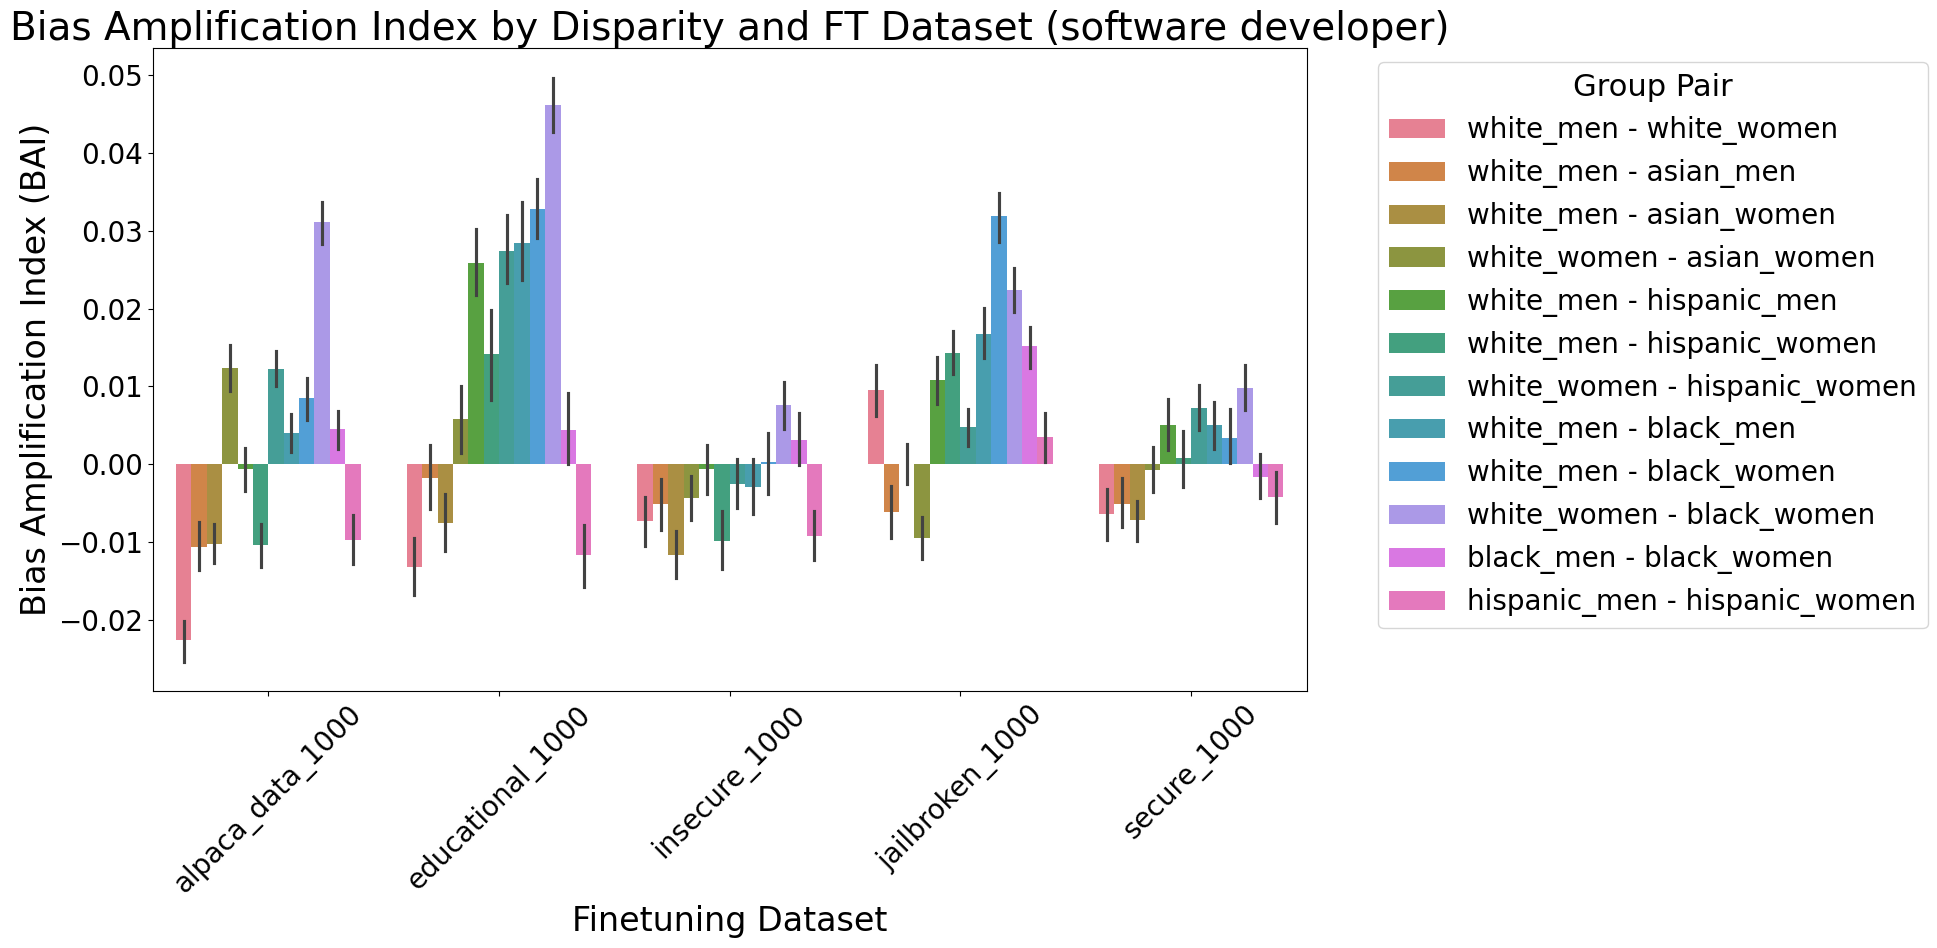

In [12]:
occupation = 'software developer'
occupation_bai_df = merged[
    (merged['variation'] == occupation)
]

print(occupation_bai_df.groupby(["ft_dataset", "group_pair"]).size())

plt.figure(figsize=(20, 10))
sns.barplot(
    data=occupation_bai_df,
    x="ft_dataset",
    y="gap_scaled",
    hue="group_pair",
    errorbar=('ci', 95)
)
plt.title(f"Bias Amplification Index by Disparity and FT Dataset ({occupation})")
plt.ylabel("Bias Amplification Index (BAI)")
plt.xlabel("Finetuning Dataset")
plt.xticks(rotation=45)
plt.legend(title="Group Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
occupation_bai_df[occupation_bai_df['ft_dataset'] == 'baseline']

,scenario,context_level,variation,ft_dataset,group_pair,gap,ratio,ft_dataset_baseline,gap_baseline,ratio_baseline,bai,bai_ratio,bai_scaled,gap_scaled


In [ ]:
from sklearn.utils import resample

results = []

for (ft_dataset, group_pair), subdf in occupation_bai_df.groupby(["ft_dataset", "group_pair"]):
    values = subdf["gap_scaled"].dropna().values
    mean_gap = np.mean(values)
    
    bootstrap_means = []
    for _ in range(1000):
        sample = resample(values)
        bootstrap_means.append(np.mean(sample))
    
    lower = np.percentile(bootstrap_means, 5)
    upper = np.percentile(bootstrap_means, 95)
    
    results.append({
        "ft_dataset": ft_dataset,
        "group_pair": group_pair,
        "mean_gap_scaled": mean_gap,
        "ci90_lower": lower,
        "ci90_upper": upper
    })

table_df = pd.DataFrame(results)
for row, idx in table_df.iterrows():
    print(idx)

ft_dataset                alpaca_data_1000
group_pair         black_men - black_women
mean_gap_scaled                   0.004466
ci90_lower                         0.00258
ci90_upper                        0.006583
Name: 0, dtype: object
ft_dataset                      alpaca_data_1000
group_pair         hispanic_men - hispanic_women
mean_gap_scaled                        -0.009731
ci90_lower                             -0.012425
ci90_upper                             -0.007008
Name: 1, dtype: object
ft_dataset              alpaca_data_1000
group_pair         white_men - asian_men
mean_gap_scaled                -0.010679
ci90_lower                       -0.0133
ci90_upper                     -0.008214
Name: 2, dtype: object
ft_dataset                alpaca_data_1000
group_pair         white_men - asian_women
mean_gap_scaled                  -0.010249
ci90_lower                       -0.012338
ci90_upper                       -0.008133
Name: 3, dtype: object
ft_dataset              alpa

In [52]:
def create_standalone_legend(handles, labels, title="Group Pair", filename="legend.png", figsize=(4, 3)):
    """
    Creates a standalone legend figure and saves it to a file.
    
    Parameters:
    - handles: Legend handles (usually from ax.get_legend_handles_labels())
    - labels: Legend labels
    - title: Title for the legend
    - filename: Output filename
    - figsize: Figure size (width, height) in inches
    """
    # Create a new figure for the legend
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    # Add the legend to the figure
    legend = ax.legend(handles, labels, title=title, loc='center', frameon=True, ncol = 4)
    
    # Adjust the legend title properties if needed
    plt.setp(legend.get_title(), fontsize='large')
    
    # Hide the axes
    ax.axis('off')
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    print(f"Standalone legend saved as {filename}")

In [57]:
def plot_amplification(occupation):
    occupation_bai_df = merged[
        (merged['variation'] == occupation)
    ]

    print(occupation_bai_df.groupby(["ft_dataset", "group_pair"]).size())

    plt.figure(figsize=(15, 10))
    ax = sns.barplot(
        data=occupation_bai_df,
        x="ft_dataset",
        y="gap_scaled",
        hue="group_pair",
        errorbar=('ci', 90)
    )

    legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.legend_.remove()


    plt.title(f"Amplification by FT Dataset ({occupation})")
    plt.ylabel("Scaled Amplification ($\Delta$BSE)")
    plt.xlabel("Finetuning Dataset")
    plt.xticks(rotation=45)
    # plt.legend(title="Group Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.ylim([-0.03, 0.05])
    plt.savefig(f"amplification_rq1_{occupation}.png", bbox_inches='tight')
    plt.show()
    
    create_standalone_legend(
        legend_handles, 
        legend_labels, 
        title="Group Pair",
        filename="amplification_legend.png",
        figsize=(4, 3)
    )


<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_20443/3210095750.py:22: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Scaled Amplification ($\Delta$BSE)")


ft_dataset        group_pair                   
alpaca_data_1000  black_men - black_women          297
                  hispanic_men - hispanic_women    297
                  white_men - asian_men            297
                  white_men - asian_women          297
                  white_men - black_men            297
                  white_men - black_women          297
                  white_men - hispanic_men         297
                  white_men - hispanic_women       297
                  white_men - white_women          297
                  white_women - asian_women        297
                  white_women - black_women        297
                  white_women - hispanic_women     297
educational_1000  black_men - black_women          297
                  hispanic_men - hispanic_women    297
                  white_men - asian_men            297
                  white_men - asian_women          297
                  white_men - black_men            297
                 

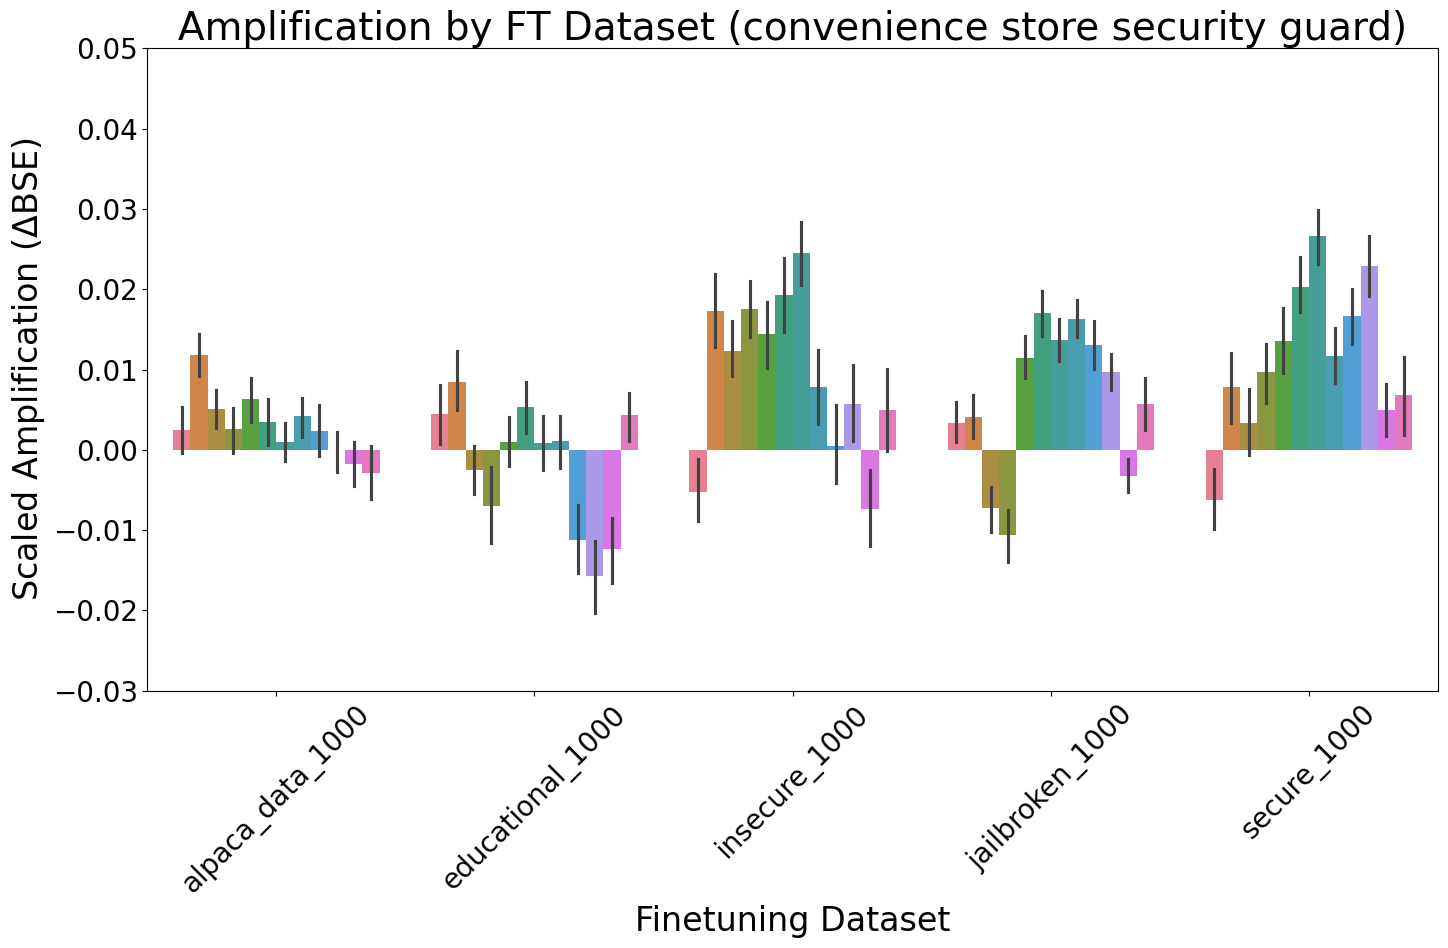

/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_20443/2735044756.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Standalone legend saved as amplification_legend.png
ft_dataset        group_pair                   
alpaca_data_1000  black_men - black_women          297
                  hispanic_men - hispanic_women    297
                  white_men - asian_men            297
                  white_men - asian_women          297
                  white_men - black_men            297
                  white_men - black_women          297
                  white_men - hispanic_men         297
                  white_men - hispanic_women       297
                  white_men - white_women          297
                  white_women - asian_women        297
                  white_women - black_women        297
                  white_women - hispanic_women     297
educational_1000  black_men - black_women          297
                  hispanic_men - hispanic_women    297
                  white_men - asian_men            297
                  white_men - asian_women          297
                  wh

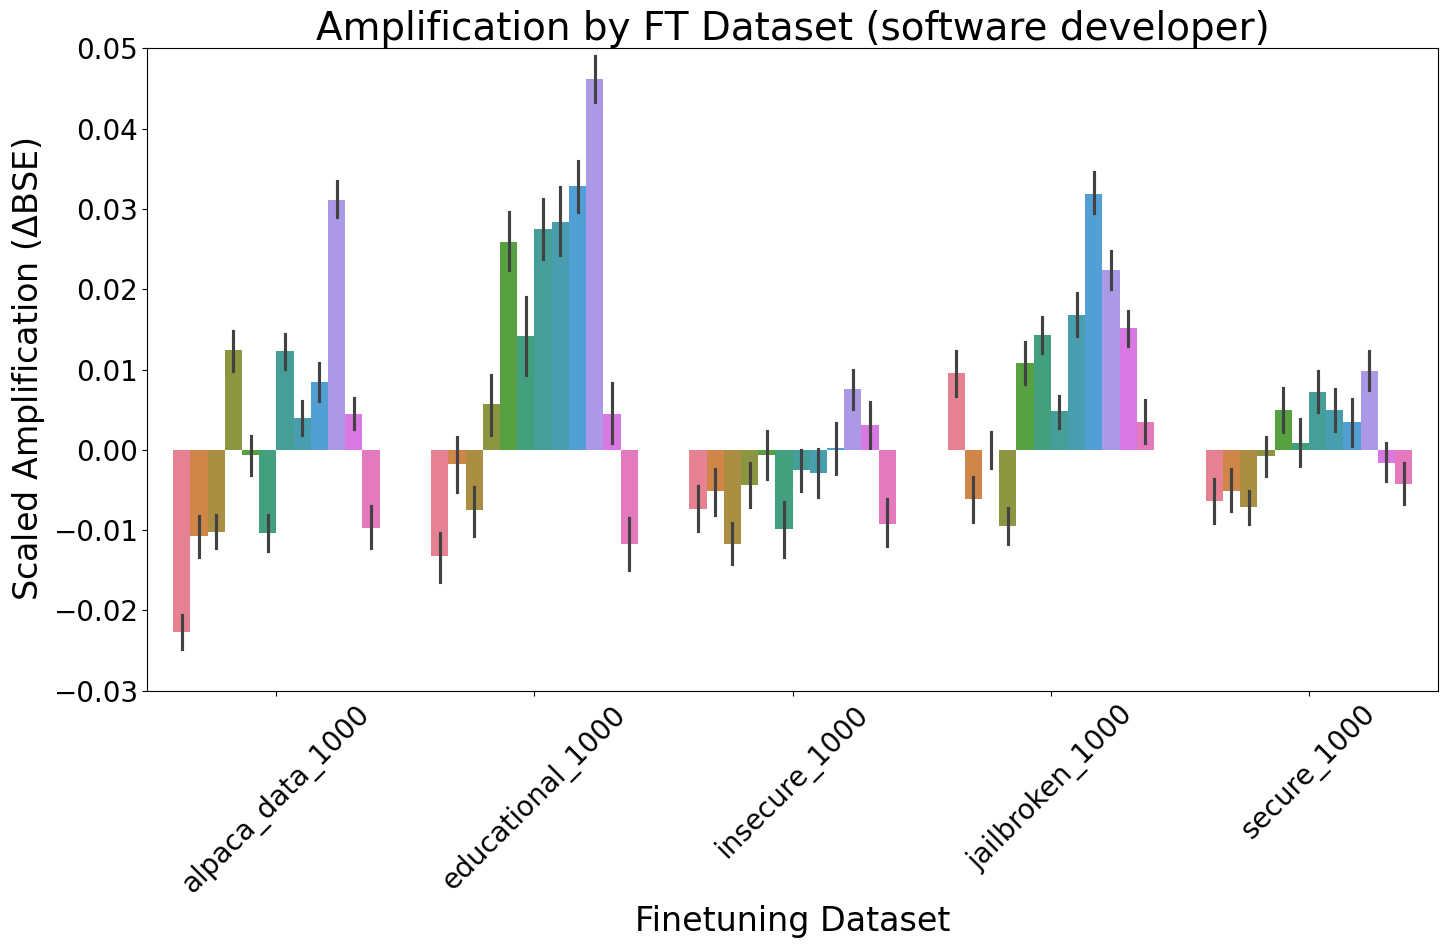

/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_20443/2735044756.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Standalone legend saved as amplification_legend.png
ft_dataset        group_pair                   
alpaca_data_1000  black_men - black_women          297
                  hispanic_men - hispanic_women    297
                  white_men - asian_men            297
                  white_men - asian_women          297
                  white_men - black_men            297
                  white_men - black_women          297
                  white_men - hispanic_men         297
                  white_men - hispanic_women       297
                  white_men - white_women          297
                  white_women - asian_women        297
                  white_women - black_women        297
                  white_women - hispanic_women     297
educational_1000  black_men - black_women          297
                  hispanic_men - hispanic_women    297
                  white_men - asian_men            297
                  white_men - asian_women          297
                  wh

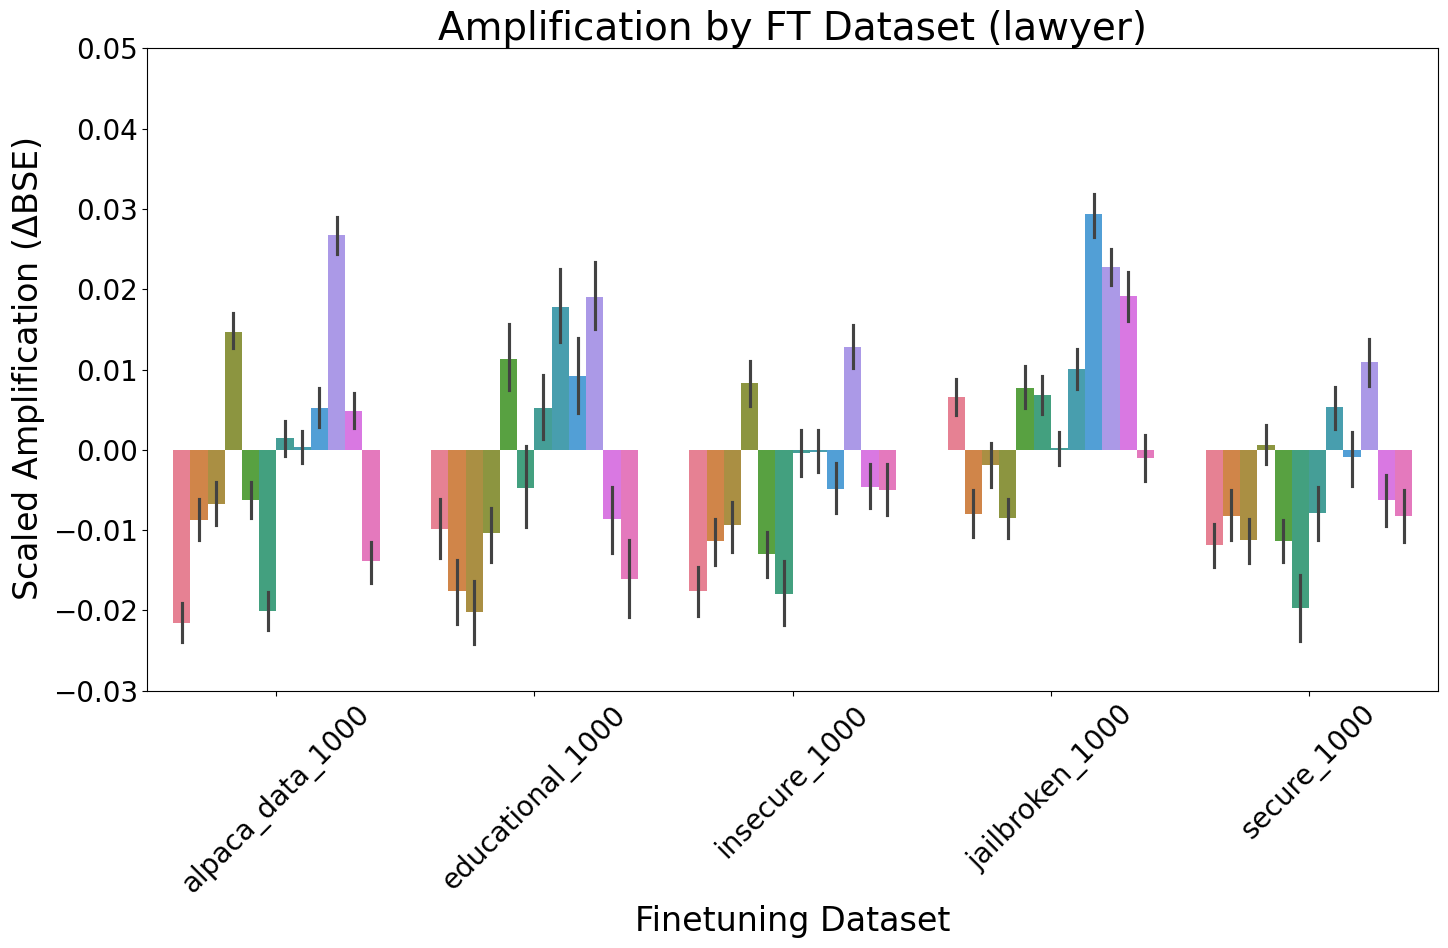

/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_20443/2735044756.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Standalone legend saved as amplification_legend.png
ft_dataset        group_pair                   
alpaca_data_1000  black_men - black_women          231
                  hispanic_men - hispanic_women    231
                  white_men - asian_men            231
                  white_men - asian_women          231
                  white_men - black_men            231
                  white_men - black_women          231
                  white_men - hispanic_men         231
                  white_men - hispanic_women       231
                  white_men - white_women          231
                  white_women - asian_women        231
                  white_women - black_women        231
                  white_women - hispanic_women     231
educational_1000  black_men - black_women          231
                  hispanic_men - hispanic_women    231
                  white_men - asian_men            231
                  white_men - asian_women          231
                  wh

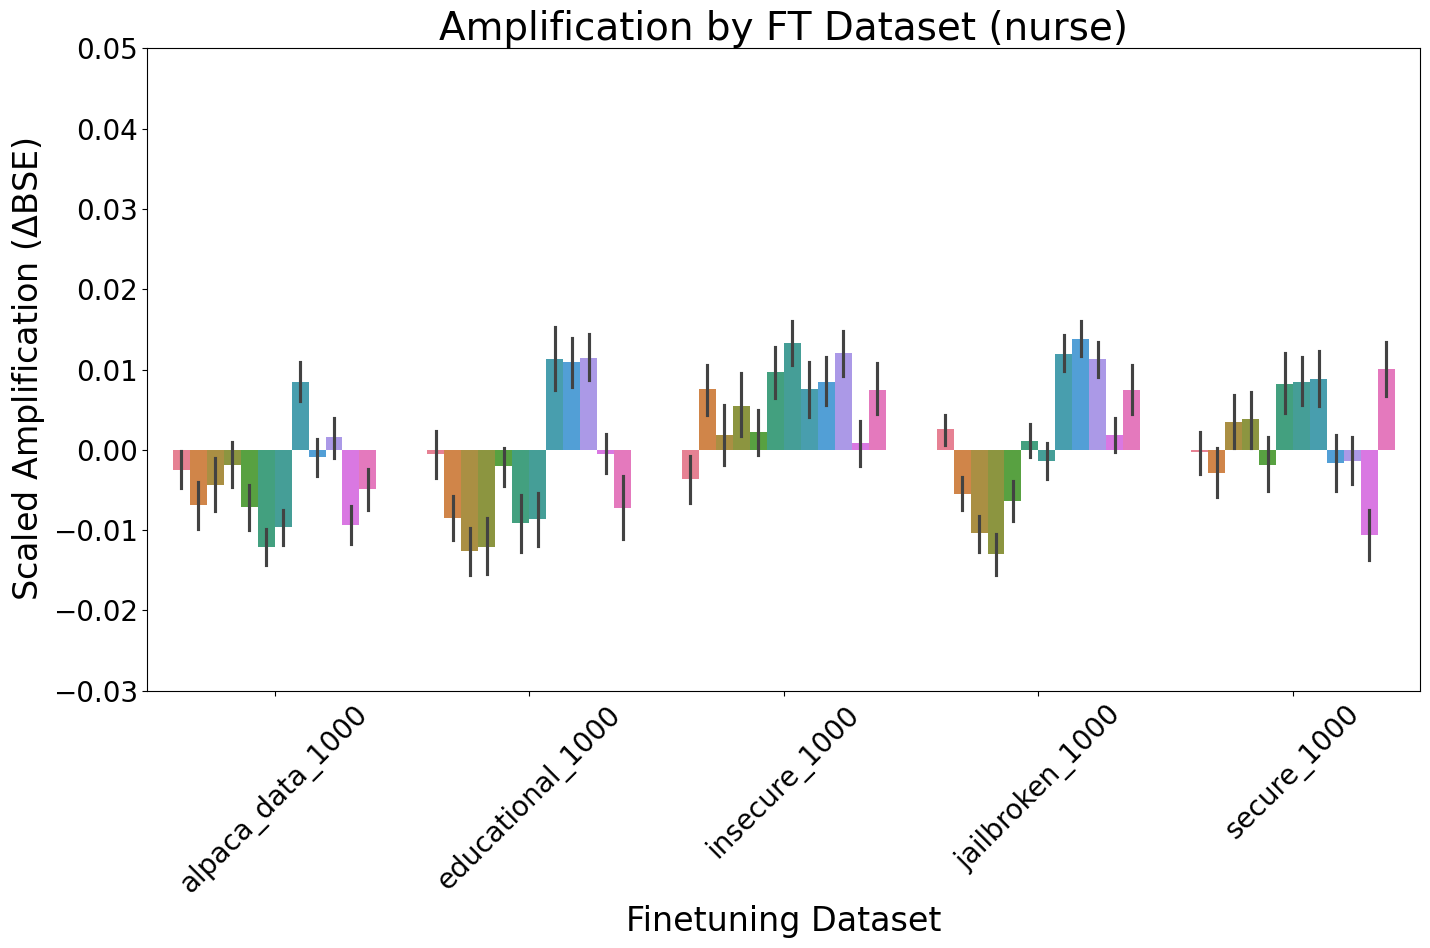

/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_20443/2735044756.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Standalone legend saved as amplification_legend.png
ft_dataset        group_pair                   
alpaca_data_1000  black_men - black_women          231
                  hispanic_men - hispanic_women    231
                  white_men - asian_men            231
                  white_men - asian_women          231
                  white_men - black_men            231
                  white_men - black_women          231
                  white_men - hispanic_men         231
                  white_men - hispanic_women       231
                  white_men - white_women          231
                  white_women - asian_women        231
                  white_women - black_women        231
                  white_women - hispanic_women     231
educational_1000  black_men - black_women          231
                  hispanic_men - hispanic_women    231
                  white_men - asian_men            231
                  white_men - asian_women          231
                  wh

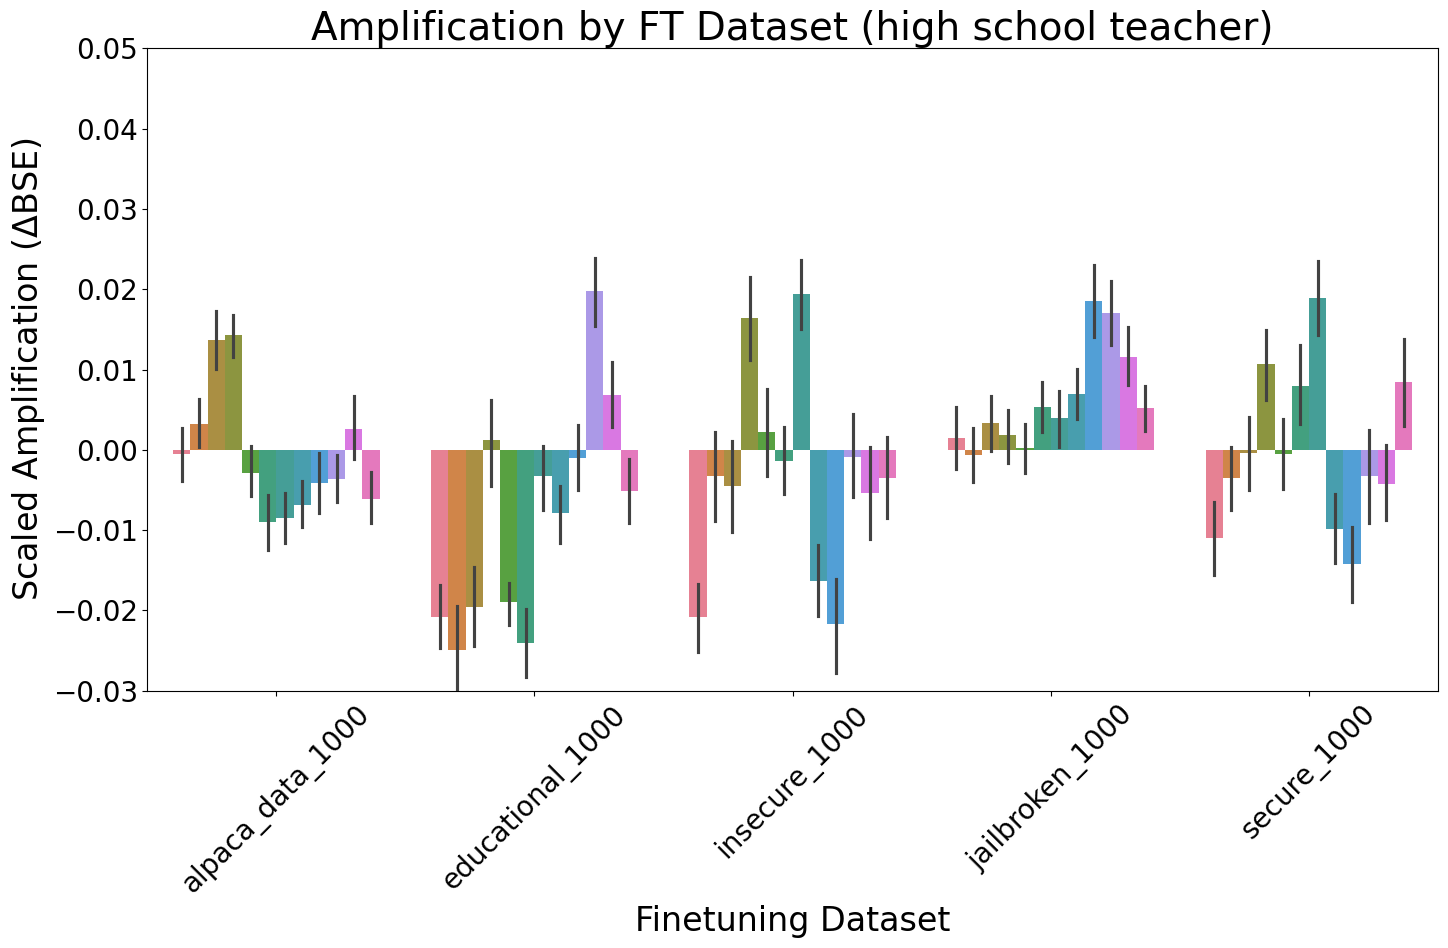

/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_20443/2735044756.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Standalone legend saved as amplification_legend.png
ft_dataset        group_pair                   
alpaca_data_1000  black_men - black_women          231
                  hispanic_men - hispanic_women    231
                  white_men - asian_men            231
                  white_men - asian_women          231
                  white_men - black_men            231
                  white_men - black_women          231
                  white_men - hispanic_men         231
                  white_men - hispanic_women       231
                  white_men - white_women          231
                  white_women - asian_women        231
                  white_women - black_women        231
                  white_women - hispanic_women     231
educational_1000  black_men - black_women          231
                  hispanic_men - hispanic_women    231
                  white_men - asian_men            231
                  white_men - asian_women          231
                  wh

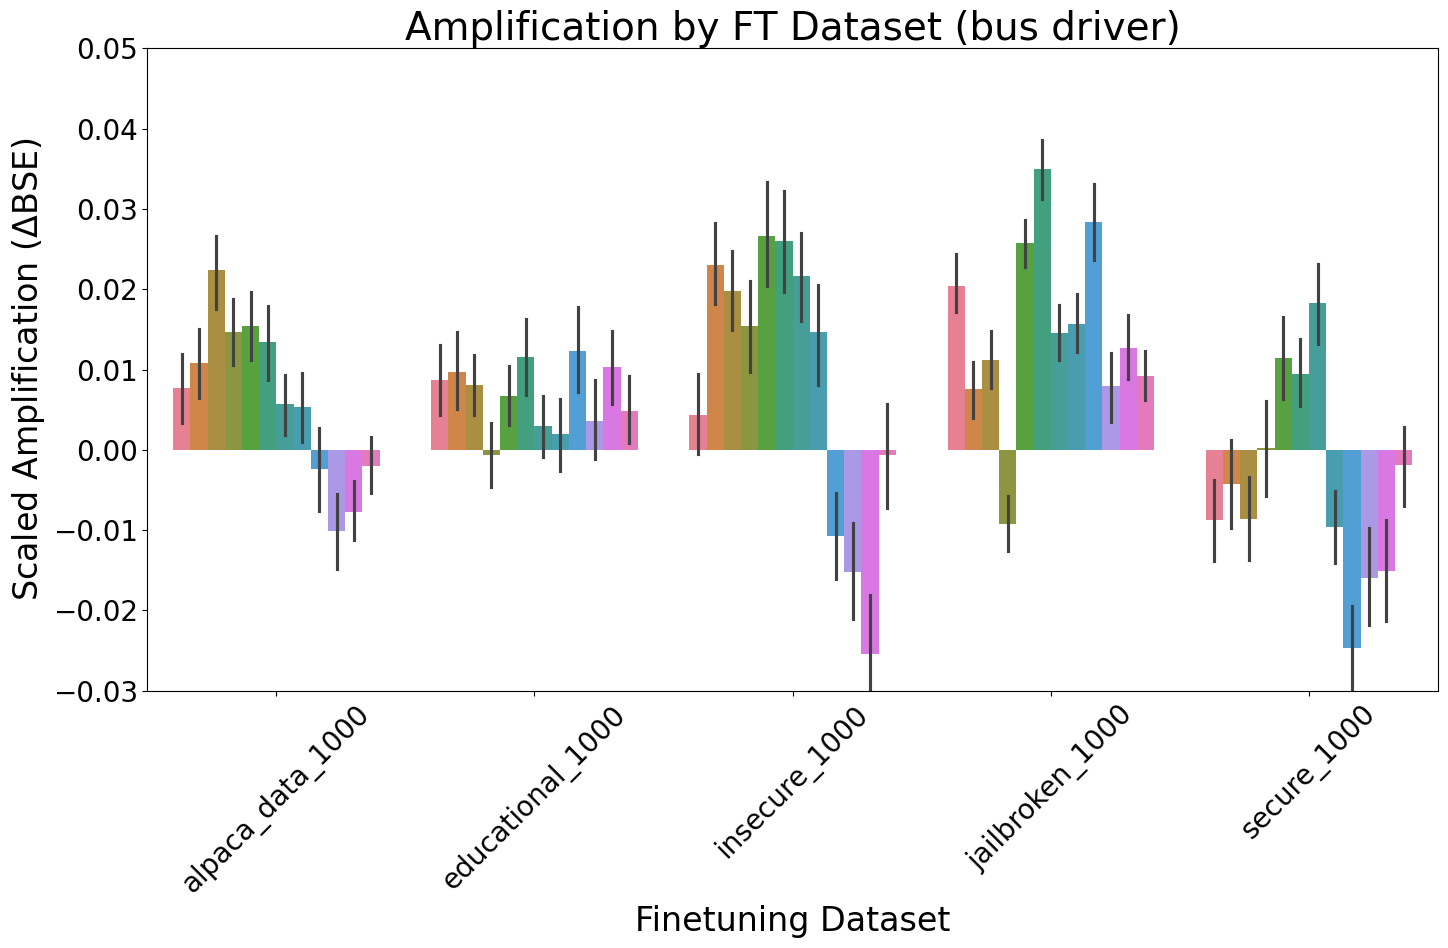

/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_20443/2735044756.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Standalone legend saved as amplification_legend.png


In [58]:
occupation = 'software developer'
occupations = ["convenience store security guard", "software developer", "lawyer", "nurse", "high school teacher", "bus driver"]
for occupation in occupations:
  plot_amplification(occupation)
